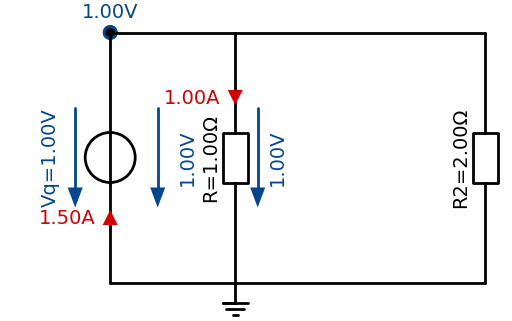

In [20]:
from CircuitCalculator.SimpleCircuit.styles.styling import select
select(style='DIN')
from CircuitCalculator.SimpleSimulation.simulator import simulate_file
simulate_file('test_simple_circuit.json')
# 

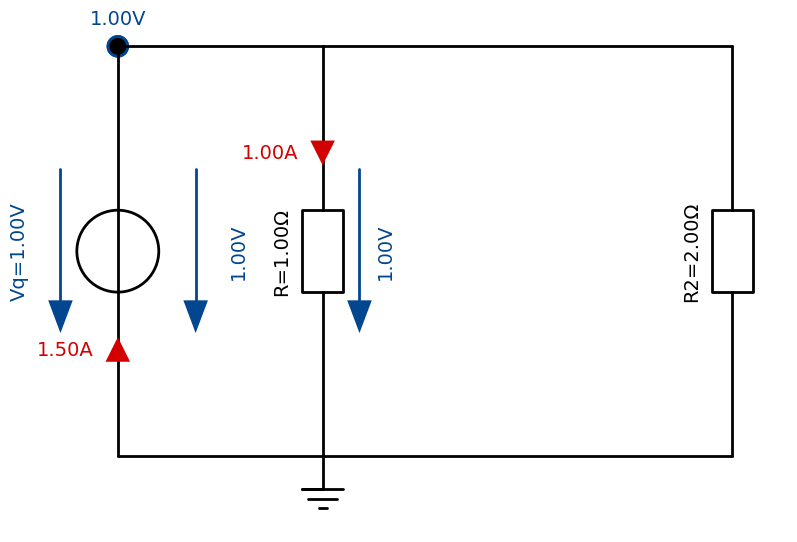

In [21]:
from CircuitCalculator.SimpleSimulation.simulator import simulate
from CircuitCalculator.dump_load import load
import matplotlib.pyplot as plt
data = load('test_simple_circuit.json')

fig, ax = plt.subplots(figsize=(10, 10))
ax.set_aspect('equal')
ax.set_axis_off()
simulate(data, circuit_ax=ax)

